In [1]:
import pandas as pd
import sklearn.metrics as mtr
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy 
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from pvlib.location import Location
import pytorch_forecasting
import time
from ranger import Ranger  
from ranger import RangerVA  
from ranger import RangerQH  
import pysolar
import datetime

import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
# Install Ranger Optimizer 

# git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
# cd Ranger-Deep-Learning-Optimizer
# pip install -e . 

# Data Load & args

In [4]:
#proprocessing
df = pd.read_csv('solar.csv')
mytime=pd.date_range('2018-1-1', '2020-12-31', freq='30T')
mytime = mytime[:-1]
df.index = mytime

#이슬점 계산
b = 17.62
c = 243.12
gamma = (b * (df['T']) / (c + (df['T']))) + np.log(df['RH'] / 100) 
dew_point = (c * gamma) / (b - gamma)
df['DP'] = dew_point

# SMAPE를 위하여 0값 제거
df['TARGET'] += 1

#시간 순차표현
Day = df.Day
df.drop(['Day'], axis=1, inplace=True)

df.Hour = df.Hour + df.Minute/60
df.drop(['Minute'], axis=1, inplace=True)

df['sin_hour'] = np.sin(2*np.pi*df.Hour/df.Hour.max())
df['cos_hour'] = np.cos(2*np.pi*df.Hour/df.Hour.max())

Day = Day%365
df['sin_day'] = np.sin(Day)
df['cos_day'] = np.cos(Day) 
# df.plot.scatter('sin_hour','cos_hour').set_aspect('equal');
# df.plot.scatter('sin_day','cos_day').set_aspect('equal')

#GHI
# 좌표는 서울로 했는데, 태양광판 좌표를 몰라서 오차가 있음
latitude = 37.532600
longitude = 127.024612

KST = datetime.timezone(datetime.timedelta(hours=9))
mydatetime = mytime.to_pydatetime()

solar_alt = []
for i in mydatetime:
    i = i.replace(tzinfo=KST)
    solar_alt.append(pysolar.solar.get_altitude(latitude, longitude, i))

solar_altitude = pd.DataFrame(solar_alt)
solar_altitude.index = df.index
df['solar_altitude'] = solar_altitude

df['GHI'] = df.DNI*np.cos((90-df['solar_altitude'])*np.pi/180)+df.DHI


In [6]:
df_temp = df.loc[:, ['Hour','DHI','DNI','WS','RH','T','DP','solar_altitude', 'GHI']]
scaler = MinMaxScaler()
df_temp = scaler.fit_transform(df_temp)
df[['Hour','DHI','DNI','WS','RH','T','DP','solar_altitude', 'GHI']] = df_temp

data = df

In [67]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)
# args
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "solar_preprocessed_fin"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 128
args.x_frames = 48*7
args.y_frames = 48*2

args.input_dim = data.shape[1]
args.hid_dim = args.y_frames*2
args.n_layers = 2 

args.lr = 0.001
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True
args.epoch = 10

args.optim = 'RMSprop' # RMSprop, Adam

# 비교
name_var1 = 'optim'
list_var1 = ['RMSprop', 'Adam']
# name_var1 = 'lr'
# list_var1 = [0.01, 0.001, 0.0001]
# name_var1 = 'hid_dim'
# list_var1 = [args.y_frames, args.y_frames*2, args.y_frames*4]
# name_var1 = 'batch_size'
# list_var1 = [32,64,128]
name_var2 = 'n_layers'
list_var2 = [1,2,3,4]
args.resultLength = 9



# Data Preparation

In [8]:
class Dataset(Dataset):
    
    def __init__(self, x_frames, y_frames, start, end):
        
        self.x_frames = x_frames
        self.y_frames = y_frames        
        
        self.start = start
        self.end = end

        self.data = data[self.start:self.end]
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data.values
        x = data[:self.x_frames]
        y = data[self.x_frames:]       

        return x, y

In [9]:
data_len = len(data)
trainset = Dataset(args.x_frames, args.y_frames,0,round(data_len*0.7))
valset = Dataset(args.x_frames, args.y_frames, round(data_len*0.7), round(data_len*0.9))
testset = Dataset(args.x_frames, args.y_frames, round(data_len*0.9), data_len)

partition = {'train': trainset, 'val':valset, 'test':testset}

# Model Define

In [10]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))        
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
#         y_pred = nn.functional.relu(y_pred)
        return y_pred

In [11]:
def Smape(true, pred):

    return 100/len(true)* np.sum(np.abs(true-pred) / (np.abs(true)+np.abs(pred)+1e-8))

In [12]:
def metric(y_pred, y_true):
    perc_y_pred = y_pred.cpu().detach().numpy().flatten()
    perc_y_true = y_true.cpu().detach().numpy().flatten()
    smape = Smape(perc_y_true, perc_y_pred)

    return 100 - smape

# Train, Validate, Test 

In [13]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=False, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    
    train_acc = 0.0
    train_loss = 0.0
    for i, (x, y) in enumerate(trainloader):      
        

        x = x.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 0].float().to(args.device)

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]
        
        y_pred = model(x)
        
#         loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss = loss_fn(y_pred, y_true)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)
        

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [14]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (x, y) in enumerate(valloader):

            x = x.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 0].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(x)

#             loss = loss_fn(y_pred.view(-1), y_true.view(-1))
            loss = loss_fn(y_pred, y_true)
            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)
            
    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [15]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (x, y) in enumerate(testloader):

            x = x.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 0].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(x)            
            test_acc += metric(y_pred, y_true)
            
    test_acc = test_acc / len(testloader)
    return test_acc,y_true, y_pred

In [16]:
def experiment(partition, args):
    
    model = LSTM(args.input_dim, args.hid_dim,args.y_frames , args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
#     loss_fn = torch.nn.MSELoss()
    loss_fn = pytorch_forecasting.metrics.SMAPE()
    #print(model.weight_ih_l0[0], model.weight_hh_l0[0])    

    if args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Ranger':
        optimizer = Ranger(model.parameters(), lr=args.lr, weight_decay=args.l2)        
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch): 
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc= validate(model, partition, loss_fn, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)        
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
    
    test_acc, test_true, test_pred = test(model, partition, args)
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    result['test_true'] = test_true.cpu().tolist()
    result['test_pred'] = test_pred.cpu().tolist()

    return vars(args), result

# Manage Experiment

In [18]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result, args):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:args.resultLength]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)
    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) 
    return df

In [53]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])

    ax[0].set_title('Train Accuracy')
    ax[0].legend(loc='lower left', title=var2)
    ax[1].set_title('Validation Accuracy')
    ax[1].legend(loc='lower left', title=var2)
    ax[2].set_title('Test Accuracy')    
    ax[2].legend(loc='lower left', title=var2)
    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]
            trainloss = list(row.train_losses)
            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.') 
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) 

def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')


    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

# execute

In [69]:
for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result, deepcopy(args))

Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=10, exp_name='solar_preprocessed_fin', hid_dim=192, input_dim=14, l2=1e-05, lr=0.001, n_layers=1, optim='RMSprop', resultLength=9, use_bn=True, x_frames=336, y_frames=96)
Epoch 0, Acc(train/val): 66.00/68.90, Loss(train/val) 0.68003/0.62207. Took 23.87 sec
Epoch 1, Acc(train/val): 80.44/71.41, Loss(train/val) 0.39113/0.57180. Took 22.75 sec
Epoch 2, Acc(train/val): 83.38/72.24, Loss(train/val) 0.33246/0.55525. Took 22.57 sec
Epoch 3, Acc(train/val): 84.40/72.81, Loss(train/val) 0.31196/0.54381. Took 22.46 sec
Epoch 4, Acc(train/val): 85.01/72.96, Loss(train/val) 0.29974/0.54076. Took 22.28 sec
Epoch 5, Acc(train/val): 85.55/73.60, Loss(train/val) 0.28897/0.52806. Took 22.51 sec
Epoch 6, Acc(train/val): 85.98/73.91, Loss(train/val) 0.28044/0.52177. Took 22.29 sec
Epoch 7, Acc(train/val): 86.41/73.67, Loss(train/val) 0.27188/0.52667. Took 22.51 sec
Epoch 8, Acc(train/val): 86.73/73.82, Loss(train/val) 0.26533/0.52352. Took 22.47

Epoch 4, Acc(train/val): 83.25/71.29, Loss(train/val) 0.33504/0.57425. Took 50.62 sec
Epoch 5, Acc(train/val): 83.91/71.33, Loss(train/val) 0.32184/0.57342. Took 50.24 sec
Epoch 6, Acc(train/val): 83.96/71.40, Loss(train/val) 0.32072/0.57200. Took 50.66 sec
Epoch 7, Acc(train/val): 83.42/71.30, Loss(train/val) 0.33155/0.57400. Took 50.26 sec
Epoch 8, Acc(train/val): 83.21/71.72, Loss(train/val) 0.33584/0.56565. Took 50.35 sec
Epoch 9, Acc(train/val): 83.11/72.57, Loss(train/val) 0.33789/0.54863. Took 50.54 sec


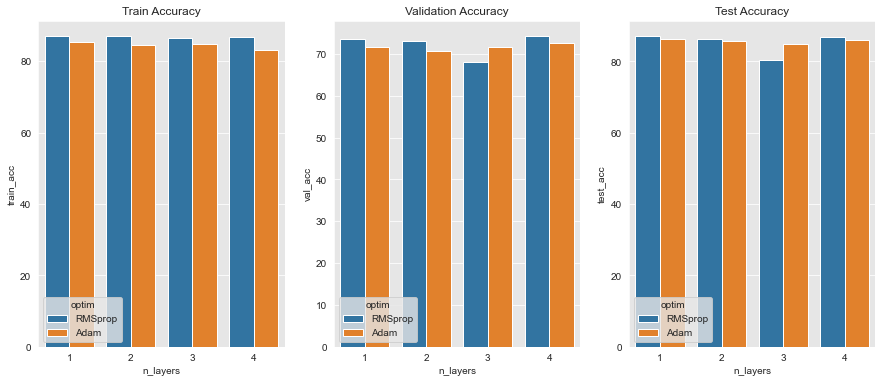

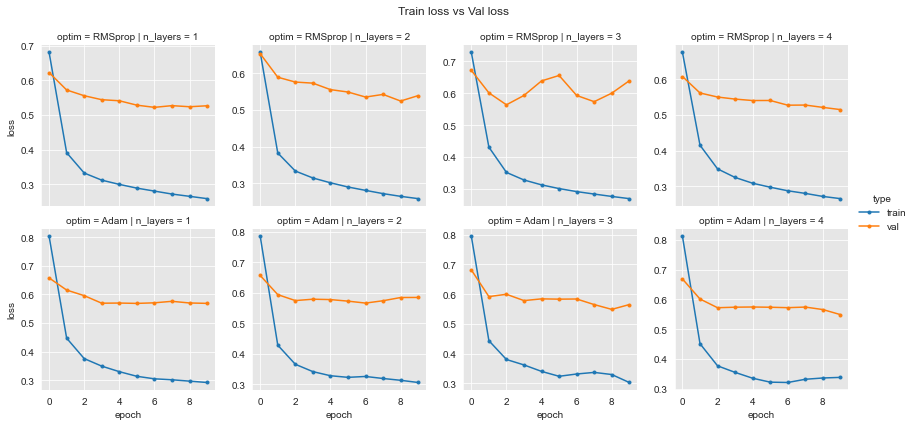

In [70]:
var1 = name_var2
var2 = name_var1
result = load_exp_result(args.exp_name)
# result = load_exp_result('solar_smape')

plot_acc(var1, var2, result)
plot_loss_variation(var1, var2, result, sharey=False) 
# plot_acc_variation(var1, var2, result, margin_titles=True, sharey=True)

In [73]:
result[['train_acc','val_acc']]

,train_acc,val_acc
0,86.742768,74.250402
1,84.832433,71.743870
2,83.105444,72.568464
3,87.065731,73.685293
4,87.057431,73.063765
5,86.550892,68.032096
6,85.408674,71.559934
7,84.722900,70.752244


In [75]:
result.loc[3]

train_losses    [0.680033196340984, 0.3911293420258542, 0.3324...
val_losses      [0.6220670938491821, 0.5718032129299946, 0.555...
train_accs      [65.99834005877445, 80.44353286984943, 83.3769...
val_accs        [68.89664538395711, 71.40983928982008, 72.2373...
train_acc                                               87.065731
val_acc                                                 73.685293
test_acc                                                87.091235
test_true       [[43.60599899291992, 42.94907760620117, 37.975...
test_pred       [[45.795570373535156, 46.79991912841797, 46.31...
exp_name                                   solar_preprocessed_fin
device                                                       cuda
batch_size                                                    128
x_frames                                                      336
y_frames                                                       96
input_dim                                                      14
hid_dim   

### 한 모델 반복수 늘리기

In [76]:
args.epoch = 50

args.n_layers = 1
args.lr = 0.001
args.batch_size = 128
args.hid_dim = args.y_frames*2
args.optim = 'RMSprop'

args.exp_name = 'final_model_50epoch'

print(args)

setting_fin, result_fin = experiment(partition, deepcopy(args))
save_exp_result(setting_fin, result_fin, deepcopy(args))

Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=50, exp_name='final_model_50epoch', hid_dim=192, input_dim=14, l2=1e-05, lr=0.001, n_layers=1, optim='RMSprop', resultLength=9, use_bn=True, x_frames=336, y_frames=96)
Epoch 0, Acc(train/val): 64.89/66.94, Loss(train/val) 0.70229/0.66126. Took 23.16 sec
Epoch 1, Acc(train/val): 79.44/71.41, Loss(train/val) 0.41116/0.57173. Took 23.21 sec
Epoch 2, Acc(train/val): 83.05/72.86, Loss(train/val) 0.33909/0.54284. Took 23.15 sec
Epoch 3, Acc(train/val): 84.27/73.35, Loss(train/val) 0.31469/0.53307. Took 22.76 sec
Epoch 4, Acc(train/val): 84.95/73.80, Loss(train/val) 0.30108/0.52393. Took 22.70 sec
Epoch 5, Acc(train/val): 85.56/74.10, Loss(train/val) 0.28890/0.51795. Took 22.84 sec
Epoch 6, Acc(train/val): 85.99/74.10, Loss(train/val) 0.28028/0.51798. Took 22.71 sec
Epoch 7, Acc(train/val): 86.36/74.01, Loss(train/val) 0.27271/0.51970. Took 23.19 sec
Epoch 8, Acc(train/val): 86.72/74.13, Loss(train/val) 0.26560/0.51745. Took 22.78 se

In [26]:
def plot_acc_fin(result):
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    
    optim = result['optim'][0]
    lr = result['lr'][0]
    layers = result['n_layers'][0]

    bars = [result['train_acc'], result['val_acc'], result['test_acc']]
    label = ['train', 'valid', 'test']

    for i, v in enumerate(bars) :
        ax.bar(i*0.5-0.5, v, 0.35,  label=label[i])
        plt.text(i*0.5-0.5, v, round(v[0], 2), fontsize = 12, 
                 horizontalalignment='center', 
                 verticalalignment='bottom') 
    
    ax.set_xticklabels('')
    ax.set_title(f'acc: optim | {optim}, lr | {lr}, layers | {layers}')

    plt.legend(loc='lower right')
    plt.show()

def plot_loss_fin(result, **kwargs):
    trainloss = list(result['train_losses'])
    train_losses = list(trainloss)[0]
    val_losses = list(result['val_losses'])[0]
    list_data = []

    for epoch, train_loss in enumerate(train_losses):
        list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch})
    for epoch, val_loss in enumerate(val_losses):
        list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.') 
    g.add_legend()
    g.fig.suptitle('Train loss & Val loss')
    g.fig.set_size_inches(10,5)
    plt.subplots_adjust(top=0.89) 

def plot_accs_fin(result,**kwargs):

    list_data = []


    train_accs = list(result['train_accs'])[0]
    val_accs = list(result['val_accs'])[0]
    test_acc = list(result['test_acc'])[0]

    for epoch, train_acc in enumerate(train_accs):
        list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch})
    for epoch, val_acc in enumerate(val_accs):
        list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')


    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy & Val Accuracy')
    g.fig.set_size_inches(10,5)
    plt.subplots_adjust(top=0.89)

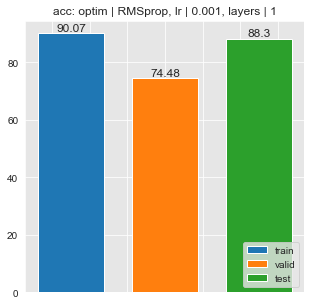

Train Loss | 0.1986,      Val Loss | 0.5104


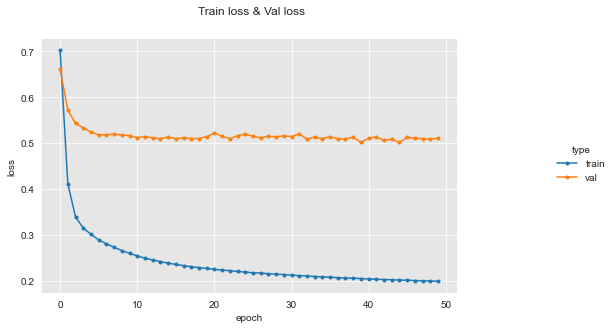

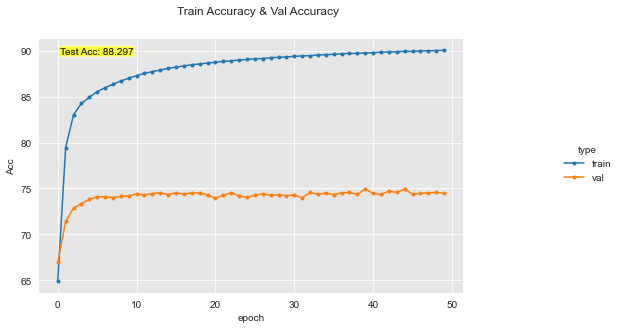

In [77]:
result_fin = load_exp_result(args.exp_name)
plot_acc_fin(result_fin)
plot_loss_fin(result_fin)
plot_accs_fin(result_fin)

print(f'Train Loss | {round(result_fin["train_losses"][0][-1], 4)},\
      Val Loss | {round(result_fin["val_losses"][0][-1], 4)}')


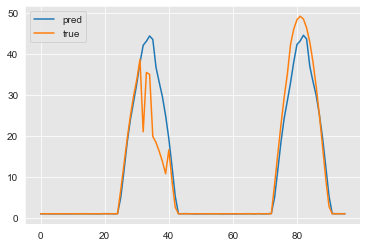

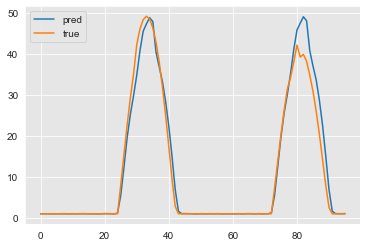

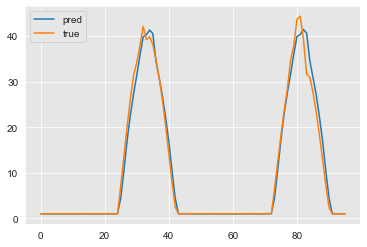

In [107]:
n = 0
m = 0

for m in range(15,128,48):    
    fin_pred = result_fin['test_pred'][n][m]
    fin_true = result_fin['test_true'][n][m]

    plt.plot(fin_pred , label='pred')
    plt.plot(fin_true, label='true')
    
    plt.legend()
    plt.show()